In [1]:
import pandas as pd
import polars as pl
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import yfinance as yf

pd.set_option("display.max.columns", 500)
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic
%matplotlib inline

## Trying out Yahoo Finance

In [8]:
etf_tickers = [
    "VTI",  # Vanguard Total Stock Market ETF (US)
    "VEA",  # Vanguard FTSE Developed Markets ETF (Ex-US)
    "VWO",  # Vanguard FTSE Emerging Markets ETF
    "SPY",  # SPDR S&P 500 ETF Trust (US)
    "QQQ",  # Invesco QQQ Trust (US)
    "EFA",  # iShares MSCI EAFE ETF (Developed Markets ex-US)
    "EEM",  # iShares MSCI Emerging Markets ETF
    "ACWI",  # iShares MSCI ACWI ETF (Global)
    "ACWX",  # iShares MSCI ACWI ex US ETF (Global ex-US)
    "IXUS",  # iShares Core MSCI Total International Stock ETF
    "VT",   # Vanguard Total World Stock ETF
    "VEU",  # Vanguard FTSE All-World ex-US ETF
    "IEMG",  # iShares Core MSCI Emerging Markets ETF
    "VXUS",  # Vanguard Total International Stock ETF
    "SCHF",  # Schwab International Equity ETF
    "VSS"    # Vanguard FTSE All-World ex-US Small-Cap ETF
]

In [10]:
etf = yf.Ticker("VTI")
hist = etf.history(period="max")


In [13]:
etf.history_metadata["currency"]

'USD'

Shit, need to account for forex movements as well if I want to measure performance in USD.

## Getting FOREX data for available currencies to USD

TBD

In [2]:
df = (
    pl.read_csv("historical.csv")
    .with_columns(pl.col("Date").str.to_datetime("%m/%d/%Y"))
    .rename(
        {
            "Date": "date",
            "Close/Last": "close",
            "Open": "open",
            "High": "high",
            "Low": "low",
        }
    )
)
df.head()

date,close,open,high,low
datetime[μs],f64,f64,f64,f64
2023-11-22 00:00:00,4556.62,4553.04,4568.43,4545.05
2023-11-21 00:00:00,4538.19,4538.77,4542.14,4525.51
2023-11-20 00:00:00,4547.38,4511.7,4557.11,4510.36
2023-11-17 00:00:00,4514.02,4509.55,4520.12,4499.66
2023-11-16 00:00:00,4508.24,4497.08,4511.99,4487.83


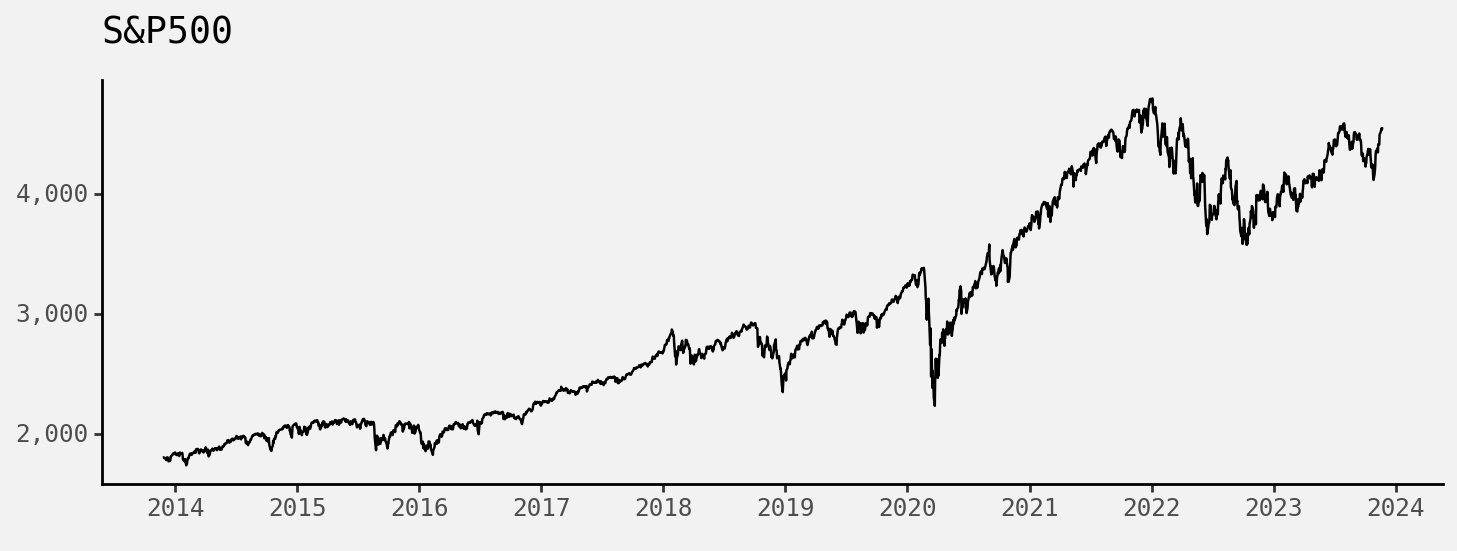

<Figure Size: (728 x 275)>

In [3]:
p = (
    ggplot(data=df, mapping=aes(x="date", y="close"))
    + geom_line()
    + scale_x_date(date_labels="%Y", date_breaks="1 year")
    + labs(title="S&P500")
    + scale_y_continuous(labels=comma_format())
    + theme(
        figure_size=[18.5 * 0.394, 7 * 0.394],
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
    )
)

p

In [4]:
p.save("Plots/stock.png", dpi=300)

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7.289000000000001 x 2.758 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: Plots/stock.png


### If staying invested for 1 year, what are the returns for each day invested since beginning of period

In [5]:
def invest(df: pl.DataFrame, wait_times: dict):
    df = df.select(["date", "close"]).sort("date")
    
    for col_name, wait_time in wait_times.items():
        df = (
            df.with_columns(
                (pl.col("close") / pl.col("close").shift(wait_time) - 1).alias(col_name)
            )
        )

    return df.drop("close")

In [6]:
wait_times = {
    "3 Months": 90,
    "6 Months": 180,
    "1 Year": 365,
    "3 Years": 365 * 3,
    "5 Years": 365 * 5,
}

Start with absolute returns (and sort categories manually):

In [7]:
abs_data = invest(df, wait_times=wait_times).melt("date").drop_nulls()

with pl.StringCache():
    pl.Series(list(wait_times.keys())).cast(pl.Categorical)
    abs_data = abs_data.with_columns(pl.col("variable").cast(pl.Categorical))

Calculate compound annual growth rate for comparison between yearly returns:

In [8]:
cagr_data = invest(df, wait_times=wait_times).melt("date").drop_nulls()
cagr_data = cagr_data.with_columns(
    (pl.col("variable").map_dict(wait_times) / 365).alias("y")
).with_columns((pl.col("value") + 1) ** (1 / pl.col("y")) - 1).select(pl.exclude("y"))

with pl.StringCache():
    pl.Series(list(wait_times.keys())).cast(pl.Categorical)
    cagr_data = cagr_data.with_columns(pl.col("variable").cast(pl.Categorical))

In [9]:
abs_data.head()

date,variable,value
datetime[μs],cat,f64
2014-03-31 00:00:00,"""3 Months""",0.038758
2014-04-01 00:00:00,"""3 Months""",0.045913
2014-04-02 00:00:00,"""3 Months""",0.046297
2014-04-03 00:00:00,"""3 Months""",0.045119
2014-04-04 00:00:00,"""3 Months""",0.032827


In [10]:
cagr_data.head()

date,variable,value
datetime[μs],cat,f64
2014-03-31 00:00:00,"""3 Months""",0.166741
2014-04-01 00:00:00,"""3 Months""",0.199681
2014-04-02 00:00:00,"""3 Months""",0.201469
2014-04-03 00:00:00,"""3 Months""",0.195989
2014-04-04 00:00:00,"""3 Months""",0.139962


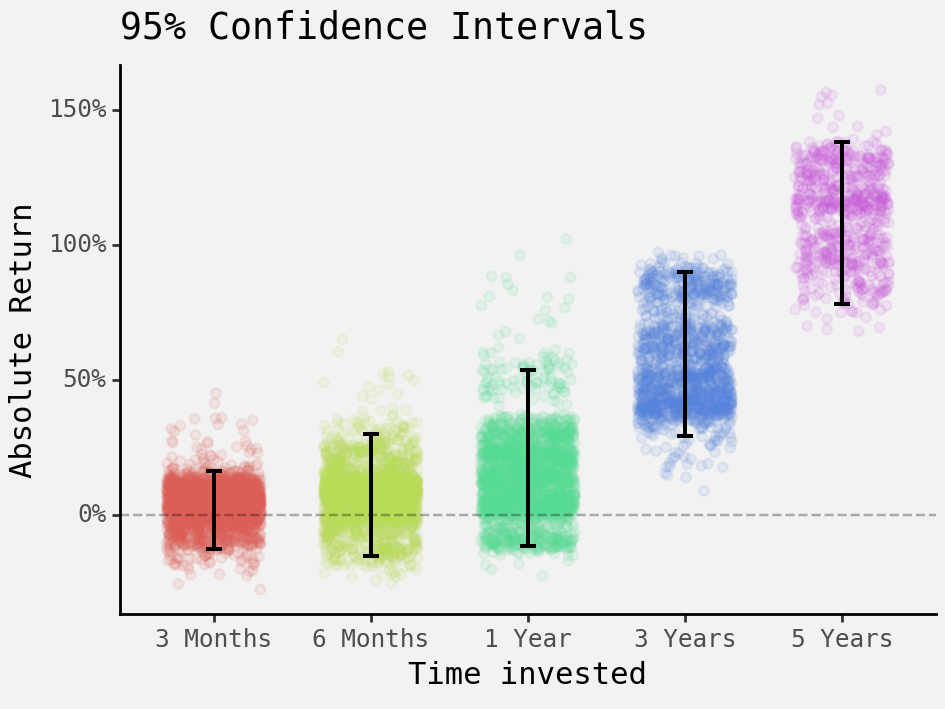

<Figure Size: (472 x 354)>

In [79]:
p = (
    ggplot(
        data=abs_data.with_columns(
            pl.col("value").quantile(0.025).over("variable").alias("lower"),
            pl.col("value").mean().over("variable").alias("middle"),
            pl.col("value").quantile(0.975).over("variable").alias("higher"),
        ),
        mapping=aes(x="variable"),
    )
    + geom_jitter(mapping=aes(y="value", colour="variable"), alpha=0.1, width=0.3)
    + geom_errorbar(mapping=aes(ymin="lower", ymax="higher"), width=0.1, size=0.5)
    # + geom_point(mapping=aes(y="middle"))
    + labs(title="95% Confidence Intervals", y="Absolute Return",
           x="Time invested")
    + geom_hline(yintercept=0, alpha=0.3, linetype="dashed")
    + scale_y_continuous(labels=percent_format())
    + theme(
        figure_size=[12 * 0.394, 9 * 0.394],
        legend_position="none",
    )
)

p

In [80]:
p.save("Plots/quantiles.png", dpi=300)

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 4.728 x 3.5460000000000003 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: Plots/quantiles.png


In [42]:
cagr_data.group_by("variable").agg(
    pl.col("value").quantile(0.025).alias("lower"),
    pl.col("value").mean().alias("middle"),
    pl.col("value").quantile(0.975).alias("higher"),
)

variable,lower,middle,higher
cat,f64,f64,f64
"""3 Months""",-0.416518,0.190366,0.856036
"""6 Months""",-0.285752,0.161125,0.699016
"""1 Year""",-0.114154,0.1438,0.536556
"""3 Years""",0.088996,0.158746,0.238653
"""5 Years""",0.122609,0.160547,0.189433


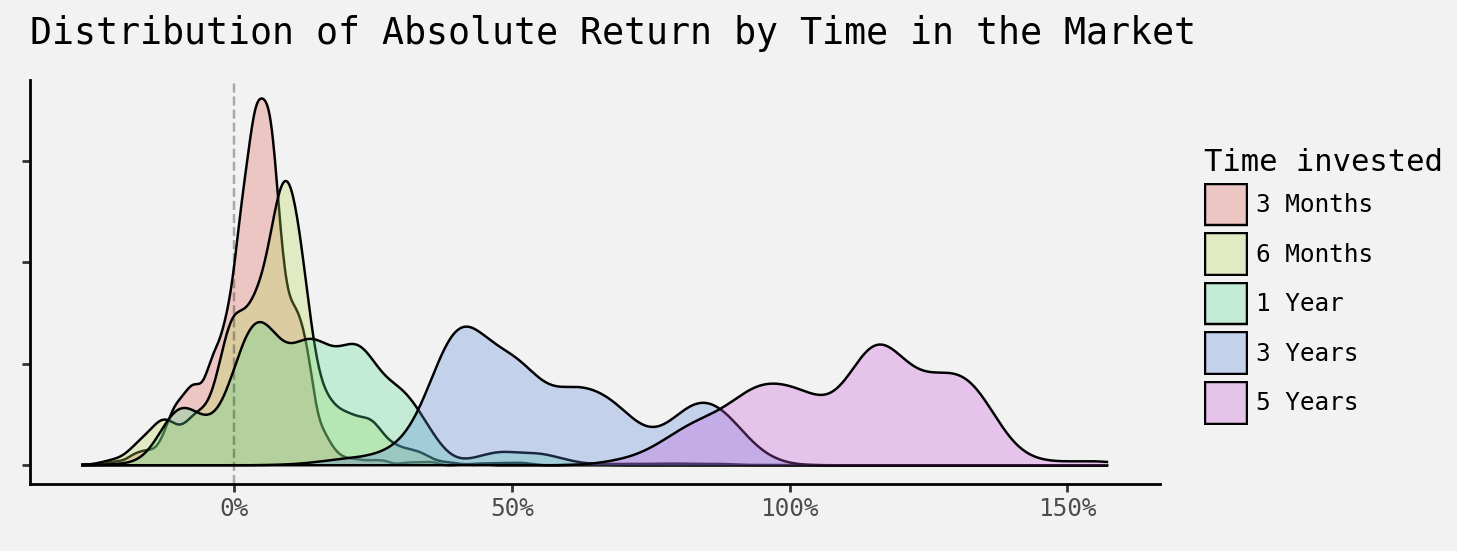

<Figure Size: (728 x 275)>

In [71]:
p = (
    ggplot(data=abs_data, mapping=aes(x="value", fill="variable"))
    + geom_density(alpha=0.3)
    + geom_vline(xintercept=0, linetype="dashed", alpha=0.3)
    + labs(title="Distribution of Absolute Return by Time in the Market",
           fill="Time invested", x="Absolute Return")
    + scale_x_continuous(labels=percent_format())
    + theme(
        figure_size=[18.5 * 0.394, 7 * 0.394],
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank()
    )
)

p

In [72]:
p.save("Plots/distribution.png", dpi=300)

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7.289000000000001 x 2.758 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: Plots/distribution.png
